# Facial Recognition Exercise: Classification based on the Olivetti Dataset. 

**Paul J. Atzberger** <br>
http://atzberger.org/ 

<img src="./data/olivetti_people_distinct_cropped.png" alt="image of distinct people in database" align="left" width="300"/>


This is an example classification problem based on the historic Olivetti Dataset put together by AT&T Laboratories around 1994. The data consists of 400 images of 40 distinct people captured by 64x64 grey-scale images [6].   While more modern
and large-scale facial datasets are currently available, the Olivetti Dataset provides a small dataset tractable for doing a few exercises and also provides some historical context [1-5] for understanding modern state-of-the-art approaches [6,7].  

In this exercise, we show how to load the image data and perform a pre-processing using Principle Component Analysis (PCA) to extract features (eigen-faces [1,2]) for a reduced description of the facial images.  You will then perform classification using these eigen-face features to get experience with Support Vector Machines (SVMs). 

Use the SVM and compare how different choices of dimension reduction and other hyper-parameters influence classification.  For further discussions of both historic and modern approaches to facial recognition see the references [1-7].

We remark that one also could use more modern techniques to perform inference more directly on the images, such as Convolutional Neural Networks (CNNs), which we shall discuss more in later lectures.  While you are also welcome as an exercise to develop a CNN to perform classification as a point of comparison, one challenge here is the small size of the Olivetti Dataset which might be insufficient for learning adquately from scratch a good CNN, but you could try transfer learning from a pre-trained CNN.

The prediction to submit is the class of the person identified in the given test images. Use the class indices labelled between 0 to 39 for the 40 distinct people in the dataset.

### References

[1] _Eiegenfaces for Recognition_, Turk, M. and Pentland, A.P., J. Cognitive Neuroscience, (1991).

[2] _Eigenfaces vs. Fisherfaces: Recognition Using Class Specific Linear Projection_, Belhumeur, P. Hespanha,J., and Kriegman, D., IEEE Transactions, (1997).

[3] _The Model Method in Facial Recognition_, Bledsoe, W. W., Technical Report PRI 15, Panoramic Research, Inc., Palo Alto, California, (1964). 

[4] _Semiautomatic Facial Recognition_, Bledsoe, W. W., Technical Report SRI Project 6693, Stanford Research Institute, Menlo Park, California, (1968).

[5] _Computer Recognition of Human Faces_, Kanade, T., Interdisciplinary Systems Research, 47, January, (1977).

[6] _Comparison of human and computer performance across face recognition experiments_, Phillips, P.,
O'Toole, A., Image and Vision Computing 32, (2014).

[7] _Deep learning_, LeCun, Y., Bengio, Y., and Hinton, G., Nature, 521, May, (2015).

[8] Images from AT&T Laboratories Cambridge.  https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html


In [1]:
import numpy as np
import pandas as pd

import scipy.linalg;

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_data = np.load("./data/olivetti_faces.npy")
target_labels = np.load("./data/olivetti_faces_target.npy")

In [3]:
print("image_data.shape = " + str(image_data.shape));
print("target_labels.shape = " + str(target_labels.shape));

image_data.shape = (400, 64, 64)
target_labels.shape = (400,)


# Face Database

In [4]:
def plot_people(data,labels):
    numPeople = 40;
    numPerCategory = 10;
    fig, axs=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    axs=axs.flatten()
    for p in range(0,numPeople):
        I=p*numPerCategory;
        pid = labels[I];
        axs[pid].imshow(data[I], cmap='gray');
        axs[pid].set_title("%d"%pid);
        axs[pid].set_xticks([]);
        axs[pid].set_yticks([]);
    plt.suptitle("The distinct people in the dataset", fontsize=18,y=0.92);
    

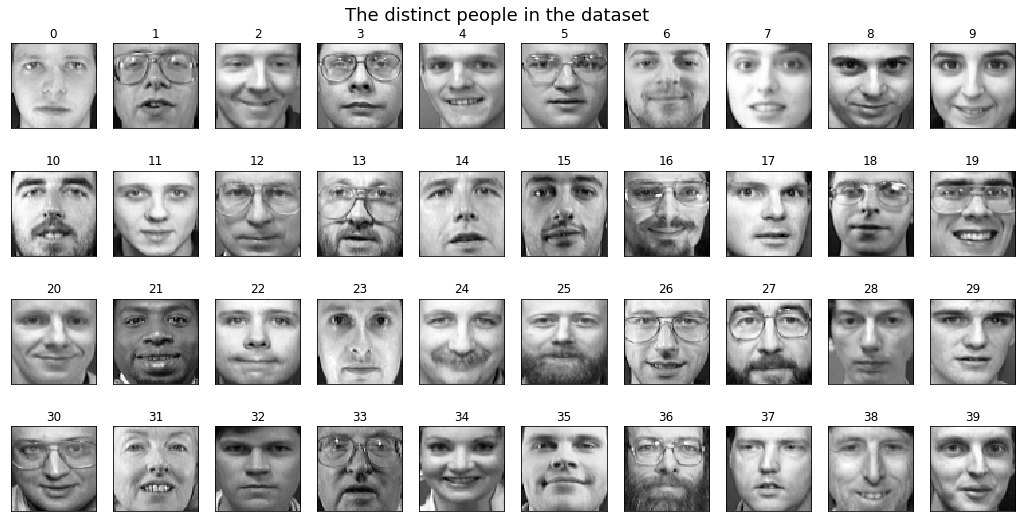

In [5]:
plot_people(image_data,target_labels);

In [6]:
def plot_people_samples(data, pids):
    numSamples = 10;
    cols       = numSamples;  # number of samples of catehory
    #rows       = (len(pids)*numSamples)/cols;
    #rows       = int(rows);
    rows = len(pids);
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(18,9));
            
    i = 0;
    for pid in pids:
        #print("pid = %d"%pid)        
        for j in range(0,numSamples):
            I = pid*numSamples + j;
            #print("i,j = (%d,%d)"%(i,j));
            axs[i,j].imshow(data[I], cmap="gray")            
            axs[i,j].set_title("%d"%pid);
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
        i = i + 1;
        
    plt.suptitle("Samples for subset of select people.", fontsize=18,y=0.92);
    

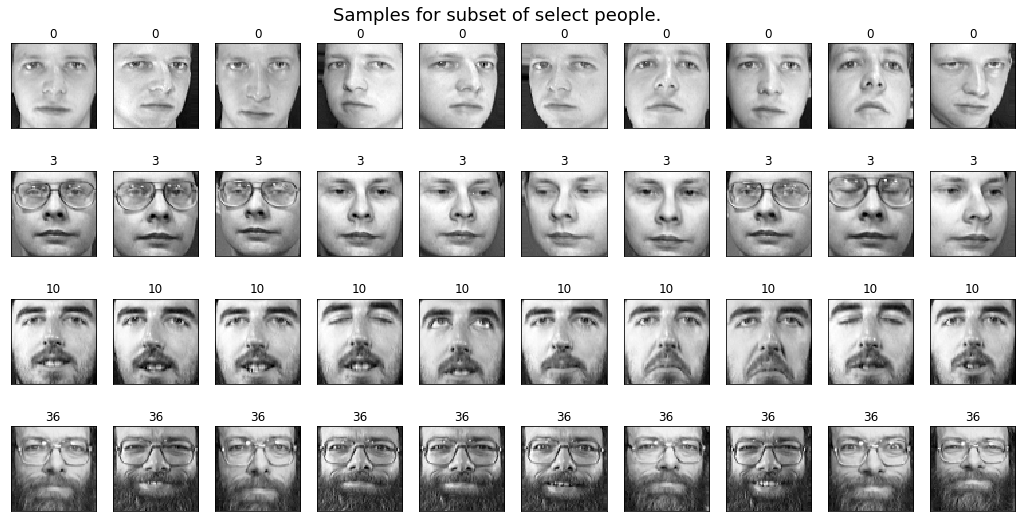

In [7]:
plot_people_samples(image_data,[0,3,10,36]);

# Perform PCA to Extract Features

In [9]:
# create a "design matrix" for the data (row is sample index, column is feature data).

numSamples = image_data.shape[0];
imageSize  = image_data.shape[1]*image_data.shape[2];
X = image_data.reshape((numSamples,imageSize));

print("X.shape = " + str(X.shape));


X.shape = (400, 4096)


In [10]:
# Now do PCA on the collection of people (downsample the features to say 80-100)

# center the data 

X_mean = (1/numSamples)*np.sum(X,0);

print("X_mean = " + str(X_mean));

Xc = X - np.outer(np.ones(numSamples), X_mean);

#print("Xc = " + str(Xc));

Xc_mean = (1/numSamples)*np.sum(Xc,0);

print("Xc_mean = " + str(Xc_mean));


X_mean = [0.40013435 0.43423545 0.4762809  ... 0.32141536 0.3136469  0.31045464]
Xc_mean = [-5.75929880e-08  8.49738717e-08  9.30204988e-08 ... -7.61914998e-08
 -2.17854977e-07 -9.15769488e-08]


In [11]:
def plot_image(data,title= None):
    if len(data.shape) == 1: # if vector, then reshape
        pixS = int(np.sqrt(data.shape[0]));
        img = data.reshape((pixS,pixS));
    else:
      img = data;
                   
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2,2));

    axs.imshow(img, cmap="gray");
    axs.set_title(title);
    axs.set_xticks([])
    axs.set_yticks([])        
    #plt.suptitle("Samples for subset of select people.", fontsize=18,y=0.92);

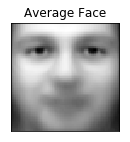

In [12]:
# Plot the "mean" face
plot_image(X_mean,title='Average Face');

In [13]:
# Compute the SVD decomposition to get the PCA 

XX = np.dot(Xc.T,Xc); # PJA: Note that Xc has data in rows, so Xc.T has data columns

U,S,Vh = scipy.linalg.svd(XX);


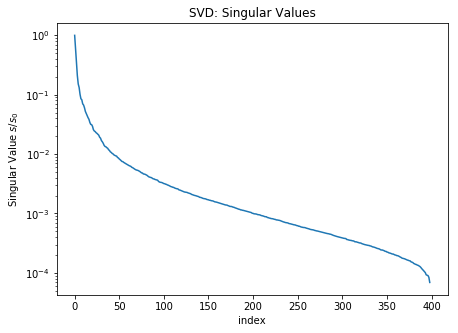

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,5));

axs.plot(S[0:399]/S[0]);
axs.set_yscale('log');
axs.set_ylabel(r'Singular Value $s/s_0$');
axs.set_xlabel('index');
axs.set_title('SVD: Singular Values');


In [15]:
def plot_sing_vectors(U):
    numSamples = U.shape[1];
    sqrtS      = int(np.sqrt(numSamples));
    rows       = sqrtS;
    cols       = sqrtS;
    
    pixS = int(np.sqrt(U.shape[0])); # size of image width
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(18,18));
            
    I = 0;
    for i in range(0,sqrtS):
        #print("pid = %d"%pid)        
        for j in range(0,sqrtS):
            data = U[:,I];            
            img = data.reshape((pixS,pixS));
            #print("i,j = (%d,%d)"%(i,j));
            axs[i,j].imshow(img, cmap="gray")            
            axs[i,j].set_title("%d"%I);
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            I += 1;
        
    plt.suptitle("Singular Vectors of Faces: Principle Components", fontsize=18,y=0.95);
    #plt.subplots_adjust(hspace=0.1,wspace=0.1);
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.0)
    

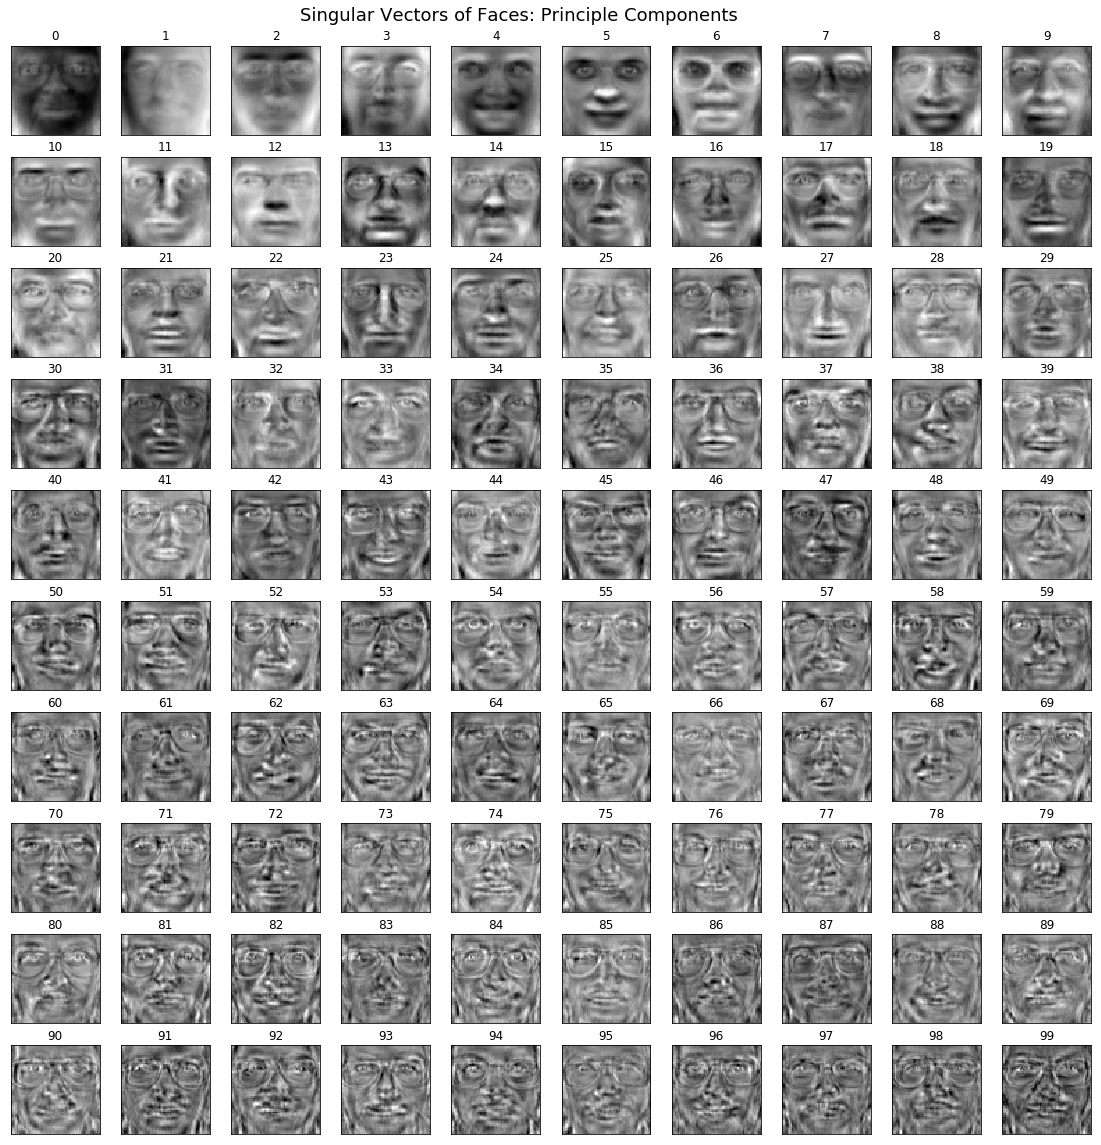

In [16]:
# Plot selectively the left singular values
#plot_image(U[:,10],title='Singular Vector');
numSqrt = 10;
plot_sing_vectors(U[:,0:numSqrt*numSqrt]);


We notice that the Principle Components seem to correspond to interesting features of the faces.  For instance, mode 5 seems to be related to location of nose, mode 6 to presence of glasses, and mode 7 to particular eye brows, etc... 

In [17]:
# Extract features from the dataset for use (project onto the singular vectors)
numFeatures = numSqrt*numSqrt;
FeatureMap = U[:,0:numFeatures].T;

Phi_X = np.dot(FeatureMap,Xc.T).T; # PJA: Projects points to the hyper-plane spanned by the singular vectors.
# Note, in the Phi_X data matrix the row index gives the sample and the columns are the features.

print("Phi_X.shape = " + str(Phi_X.shape));

Phi_X.shape = (400, 100)


Now, perform classifcation using the extracted features $\Phi(X)$ as the input.

# Classification using SVM

**_Exercise 1:_** Develop a binary SVM classifier that predicts if the image is the person with id=36 or is not.  Be sure to explore different choices of kernels, such as linear, polynomial, RBF, and hyper-parameters for the SVM.

**_Exercise 2:_** Develop a general multi-class SVM classifier that predicts which of the 40 people is shown in the given image.  Be sure to explore different choices of kernels, such as linear, polynomial, RBF, and hyper-parameters for the SVM.


In [18]:
# Perform classification using SVM 

# <develop your codes starting here>